In [10]:
from quantization import load_model
import torch
exp =  201
model = load_model(exp)

Using augmentations ['h_roll', 'flip']
TOTAL ELEMENTS 7211
TOTAL ELEMENTS 2463
Got NaN in image /Data/geosciences/TP_5/data/validation/images/well_15_patch_201.npy
Got NaN in image /Data/geosciences/TP_5/data/validation/images/well_15_patch_202.npy


In [11]:
model.count_parameters()

1904135

In [24]:
params = torch.cat([p.flatten() for p in model.parameters() if p.requires_grad])


In [25]:
params = params.detach().cpu().numpy()

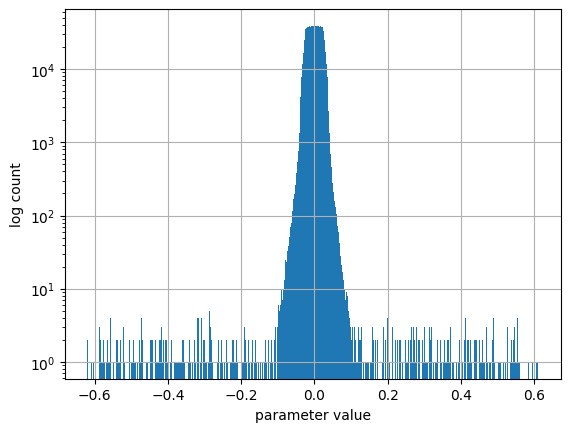

In [28]:
from matplotlib import pyplot as plt
plt.hist(params, bins=1000)
plt.yscale('log')
plt.ylabel('log count')
plt.xlabel('parameter value')
plt.grid()
plt.show()

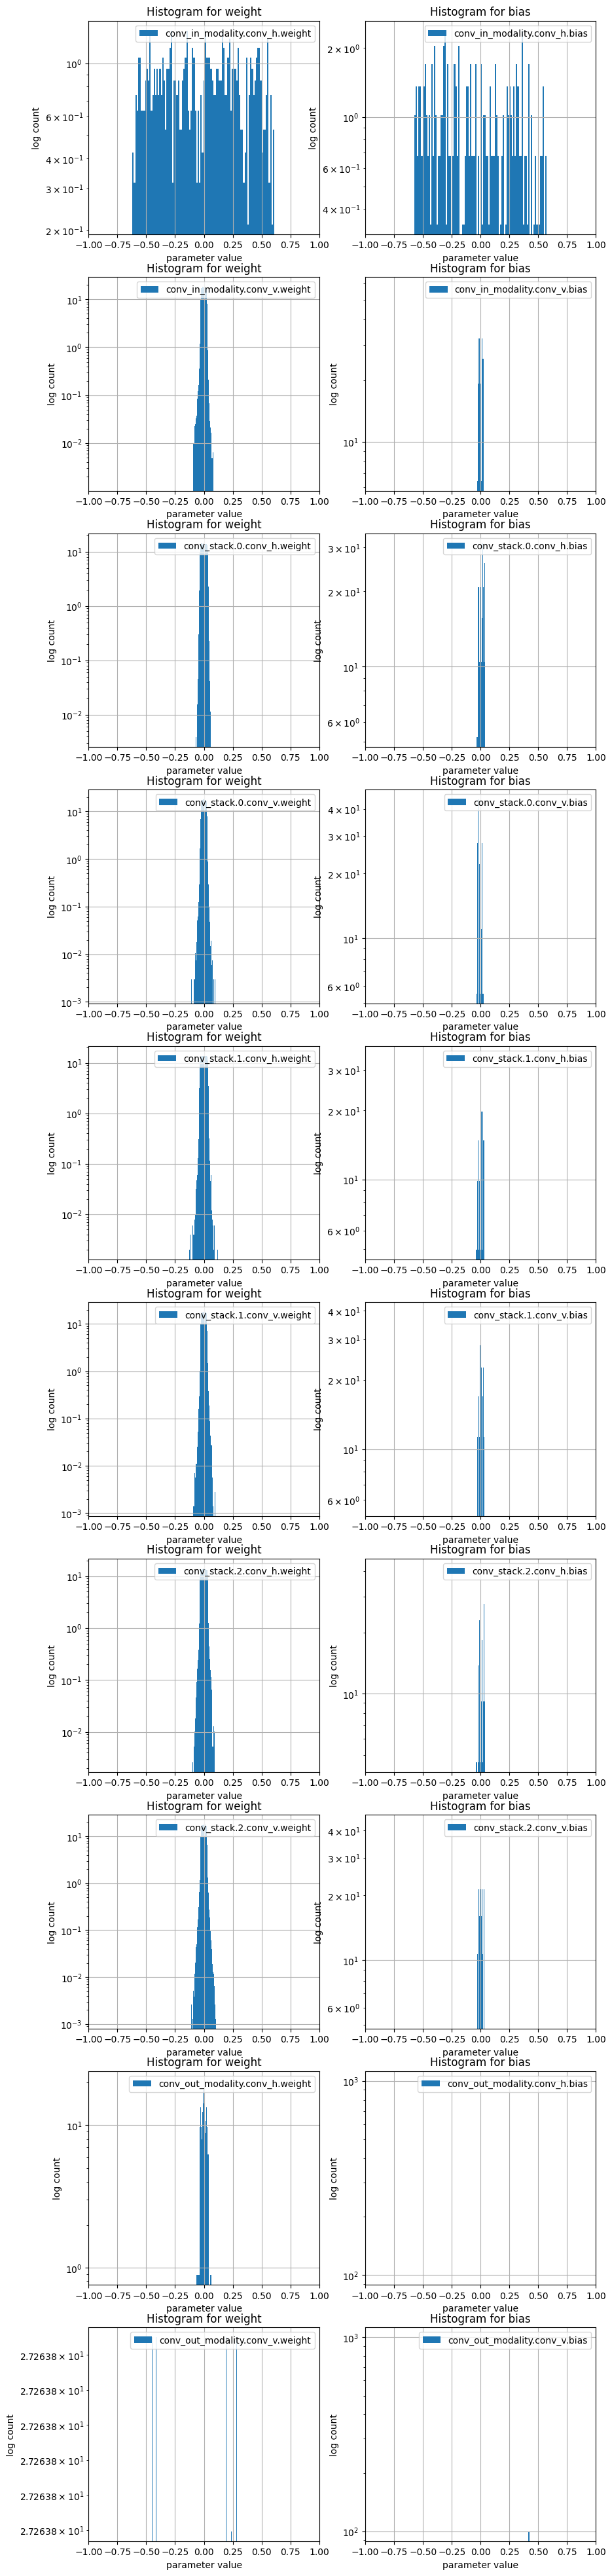

In [50]:
tot = len([1 for _ in model.named_parameters()])
from matplotlib import pyplot as plt
plt.figure(figsize=(10, tot//2*5))
for idx, (name, param) in enumerate(model.named_parameters()):
    if 'bias' not in name:
        plt.subplot(tot//2, 2, idx//2 *2 +1)
    else:
        plt.subplot(tot//2, 2, idx//2 *2 +2)
    if param.requires_grad:
        layer_params = param.detach().cpu().numpy().flatten()
        plt.hist(layer_params, bins=100, density=True, alpha=1, label=name)
        # plt.title(f'Histogram for Layer: {name}')
        plt.title('Histogram for weight' if 'weight' in name else 'Histogram for bias')
        plt.yscale('log')
        plt.ylabel('log count')
        plt.xlabel('parameter value')
        plt.legend()
        plt.xlim(-1., 1.)
        plt.grid()
plt.suptitle('Histogram of weights and biases for each layer')
plt.show()
